## Import Model

In [1]:

from ModulationPredictionCNN import ModulationPredictionCNN
activation = 'relu'
#model = ModulationPredictionCNN()
model = ModulationPredictionCNN(activation=activation)

## Import Data

In [2]:
import scipy.io as sio
import numpy as np
IQSamples = sio.loadmat('ModulationData.mat')
LBSamples = sio.loadmat('Labels.mat')
data = IQSamples['frameswhole']
label =  LBSamples['IQDataLabel']
n_samples = data.shape[-1]
data = np.squeeze(np.moveaxis(data, [0, 1, 2, 3], [-3, -2, -1, -4]))
print(data.shape)
print(label.shape)

(110000, 2, 1024)
(110000,)


In [3]:
print(np.unique(label))
label_dict = {'16QAM ':0, '64QAM ':1, '8PSK  ':2, 'B-FM  ':3, 'BPSK  ':4, 'CPFSK ':5, 'DSB-AM':6, 'GFSK  ':7,
 'PAM4  ':8, 'QPSK  ':9, 'SSB-AM':10}
lbl = np.zeros(n_samples)
for i in range(n_samples):
    lbl[i] = label_dict[label[i]]
label = lbl

['16QAM ' '64QAM ' '8PSK  ' 'B-FM  ' 'BPSK  ' 'CPFSK ' 'DSB-AM' 'GFSK  '
 'PAM4  ' 'QPSK  ' 'SSB-AM']


In [4]:
from sklearn.model_selection import train_test_split
import torch
'''
shuffled_idx = np.random.permutation(range(n_samples))
n_samples = 10000
data = data[shuffled_idx[:n_samples]]
label = label[shuffled_idx[:n_samples]]
'''
def label2onehot(lbl):
    if len(lbl.shape) == 1:
        d = np.zeros((lbl.size, lbl.max() + 1))
        d[np.arange(lbl.size), lbl] = 1
    else:
        d = lbl
    return d

def onehot2label(d):
    if len(d.shape) == 1:
        lbl = d
    else:
        lbl = d.argmax(axis=1)
    return lbl

label = onehot2label(label)
# Split test data
x_data, x_test, y_data, y_test = train_test_split(data, label, test_size=0.2, random_state=1)
# Split validation data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=1)


train_set = {'data':torch.tensor(x_train).float(), 'labels':torch.tensor(y_train).float() }
val_set = {'data':torch.tensor(x_val).float(), 'labels':torch.tensor(y_val).float()}
print(x_train.shape, x_val.shape)


(70400, 2, 1024) (17600, 2, 1024)


## Train Model

In [5]:
import torch.nn as nn
import torch
from Train import train_model

model_file = 'Models/'+activation+'_model.pt'
num_epochs = 100
batch_size = 32
learning_rate = 0.00001
criterion = nn.CrossEntropyLoss()
computing_device = torch.device("cuda")

model, Loss, Accuracy = train_model(model, model_file, train_set, val_set, num_epochs, batch_size, learning_rate, criterion, computing_device)




Model on CUDA? True
Training complete after 101 epochs


## Test Model

In [10]:
from ModulationPredictionCNN import ModulationPredictionCNN
import torch
import torch.nn as nn

def calculate_accuracy(model, data, label, batch_size, computing_device):
    n_samples = data.shape[0]
    n_minibatch = int((n_samples+batch_size-1)/batch_size)
    accuracy = 0
    I = np.arange(n_samples)
    for i in range(n_minibatch):
        idx = I[batch_size*i:min(batch_size*(i+1), n_samples)]
        dt = data[idx].to(computing_device)
        lbl = label[idx]
        output = model(dt).detach()
        output = output.cpu().numpy()
        output = np.argmax(output,axis=1)

        accuracy += np.sum(output == lbl)

    return accuracy/n_samples

model = ModulationPredictionCNN(activation)
batch_size = 1000
computing_device = torch.device("cuda")
model.load_state_dict(torch.load(model_file))
model.to(computing_device)

x_test = torch.tensor(x_test).float().to(computing_device)
accuracy = calculate_accuracy(model, x_test, y_test, batch_size, computing_device)
print('Test Accuracy = ', accuracy)

x_train = torch.tensor(x_train).float().to(computing_device)
accuracy = calculate_accuracy(model, x_train, y_train, batch_size, computing_device)
print('Train Accuracy = ', accuracy)



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test Accuracy =  0.8207727272727273
Train Accuracy =  0.84546875


## Plot Loss

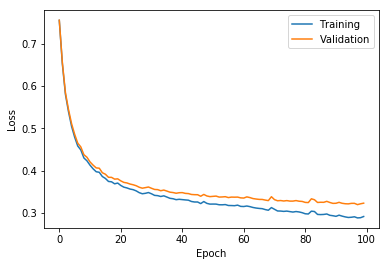

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
epochs = [i for i in range(len(Loss['train']))]
plt.plot(epochs, Loss['train'])
plt.plot(epochs, Loss['valid'])
plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig(activation+'_model_loss')
plt.show()

## Plot Accuracy

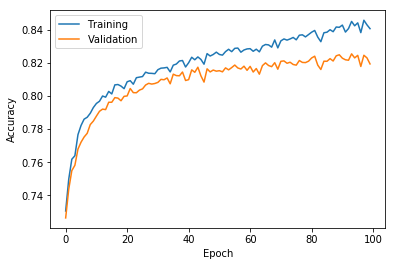

In [8]:
plt.plot(epochs, Accuracy['train'])
plt.plot(epochs, Accuracy['valid'])
plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig(activation+'_model_acc')
plt.show()

## Plot Confusion Matrix

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(22000,)
float64


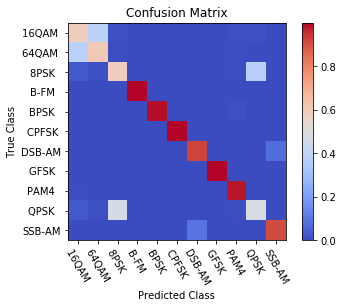

In [9]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt


def get_output(model, data, batch_size, computing_device):
    n_samples = data.shape[0]
    n_minibatch = int((n_samples+batch_size-1)/batch_size)
    accuracy = 0
    I = np.arange(n_samples)
    Output = []
    for i in range(n_minibatch):
        idx = I[batch_size*i:min(batch_size*(i+1), n_samples)]
        dt = data[idx].to(computing_device)
        out = model(dt).detach()
        out = out.cpu().numpy()
        out = np.argmax(out,axis=1)
        Output.extend(list(out))

    return np.asarray(Output)

y_pred = get_output(model, torch.tensor(x_test).float(), 1000, computing_device)
print(y_pred.shape)
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_mat = confusion_mat.astype(float)
print(confusion_mat.dtype)
for r in range(11):
    n_r = y_test[y_test == r].shape[0]
    for c in range(11):
        confusion_mat[r,c] = confusion_mat[r,c]/n_r


plt.imshow(confusion_mat, cmap='coolwarm', interpolation='nearest')
plt.title('Confusion Matrix')
plt.xticks(np.arange(11), label_dict.keys(), rotation=300)
plt.yticks(np.arange(11), label_dict.keys(), rotation=0)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.colorbar()
plt.savefig(activation+'_model_conf',  bbox_inches = 'tight')
plt.show()
